<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/11.00.Aula-Modelos_individuais_multiplas_estruturas_4.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos individuais estocásticos com múltiplas estruturas de conexão - parte III](10.00.Aula-Modelos_individuais_multiplas_estruturas_3.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Modelos individuais estocásticos com múltiplas estruturas de conexão - parte IV

## Objetivos

- Continuar o estudo de **modelos estocásticos individuais espacialmente estruturados e com evolução temporal discreta.**

- Modificando o código, de forma a demandar **menos memória**, ao custo de **mais processamento computacional**.

**Importando bibliotecas e definindo funções a serem usadas abaixo**

In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path
from sys import getsizeof
from functools import partial

import random

import numpy as np
from scipy.integrate import solve_ivp

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 06/May/2020


In [3]:
sns.set_style("darkgrid")

### Descrição do modelo no artigo Ferguson et al (2006)

- Passos temporais de $\Delta t = 0.25 \,\texttt{dias} = 6\,\texttt{horas}$.

- A cada passo de tempo, um indivíduo suscetível tem probabilidade $1 - e^{-\lambda_i \Delta t}$ de ser infectado, onde $\lambda_i$ é a taxa de risco instantâneo de infecção.

- $\lambda_i$ vem de três fontes: residência, local de trabalho e encontros aleatórios (mais detalhes nas [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf) do artigo [Ferguson et al (2005)](#Referências)

- O contatos aleatórios dependem da distância através do uso de "modelos de gravidade" (?), representando contatos aleatórios associados a deslocamentos e viagens.
    
- O *kernel* de decaimento espacial tem a mesma forma que a função de alocação de trabalhadores: $f(d) = 1/(1+(d/a)^b)$, onde $a=4\,\texttt{km}$ e $b=3$.
    

### Descrição do modelo

- Usamos o modelo genérico conforme descrito nas [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf) do [Ferguson et al (2005)](#Referências).

- A **região geográfica** é um domínio $\Omega\subset \mathbb{R}^2$.

- A **população total** é um inteiro $N$.

- Há um determinado número de **residências**.

- Há quatro tipos de **lugares** (*places*), $n_p = 1, 2, 3, 4$, com os três primeiros representando tipos de **escola**, segundo a escolarização, e o último, o **local de trabalho**.

- Um **indivíduo** $i\in \{1, \ldots, N\}$ é representado por

    - sua **idade** $a_i$;
    
    - sua **residência** $h_i$ (determinada pela função de densidade populacional e dados de censo da pirâmide etária);

    - seu **local de estudo/trabalho** $l_i^j$;
    
    - o seu **estado** $I_i$, de acordo com $I_i = 1$, se infectado (ou contagioso?), ou $I_i=0$, caso contrário.
    
    - o **grau da infecção** $C_i$, de acordo com $C_i=1$, se severa, ou $C_i=0$, caso contrário. A cada nova infecção, o indivíduo recém-infectado é aleatoriamente selecionado se $C_i=0$ ou $1$, com 50% de chance para cada grau.
    
    - o **instante de infecção** $\tau_i$, indicando o instante em que o indivíduo $i$ se tornou infectado (contagioso?)
    
    - a **força de infecção** $\lambda_i$, detalhada mais abaixo.
    
- Quantidades derivadas:

    - $n_i$ é o **número de pessoas na residência** do indivíduo $i$;
    
    - $m_i^j$ é o **número de pessoas no mesmo local** do indivíduo $i$.

### Força de infecção

A **força de infecção** $\lambda_i$ de cada indivíduo é dada por

$$ 
  \begin{align*}
    \lambda_i & = \frac{1}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k \beta_h\kappa(t-\tau_k)\rho_k(1 + C_k (\omega-1)) \quad \textrm{(na residência)} \\
    & \quad + \sum_{j, k; l_k^j = l_i^j} \frac{I_k \beta_p^j\kappa(t-\tau_k)\rho_k(1 + C_k(\omega\psi_p^j(t-\tau_\kappa)-1)}{m_i^j} \quad \textrm{(na local de escola/trabalho)} \\
    & \quad + \frac{\sum_k I_k\zeta(a_i)\beta_c\kappa(t-\tau_k)f(d_{ik})\rho_k(1 + C_k (\omega-1))}{\sum_l f(d_{il})} \quad \textrm{(global)},
  \end{align*}
$$

onde

- $i, k$ são índices de indivíduos;

- $j$ é um índice de local;

- $\beta_h$, $\beta_p^j$ e $\beta_c$ são coeficientes de transmissão em **residências**, **locais de trabalho/escola** e em toda a região (rede **global**);

- $\alpha=0.8$ é uma potência para escalonar em função do tamanho da residência;

- $\omega=2$ é um fator de contágio para infecções severas, em relação a não-severas.

- $\psi_p^j = 0.1, 0.2, 0.25, 0.5$, para $j=1,2,3,4$ e $s>0.25 \;\texttt{dias}$, e $\psi_p^j=0$, caso contrário, são os fatores de taxa de contato, em cada tipo de local, para infecções severas, como função do tempo $s=t-\tau$ desde o início do contágio.

- $f(d_{ik})$ é o núcleo de distância e $d_{ik}$ é a distância euclidiana entre os indivíduos $i$ e $k$.

- $\zeta(a_i)$ é a taxa relativa de contato em relação à mobilidade de um indivíduo com idade $a_i$.

- $\rho_k = 1$ é a taxa relativa de infecção do indivíduo $k$. (Mais geralmente $\rho_k$ pode ser dado por uma distribuição $\gamma$ com média $1$ e fator de forma $\alpha=0.2$.)

### Caso simplificado de parâmetros

- Vamos simplificar assumindo: $\kappa \equiv 1$; $\rho_k \equiv 1$; $\omega_k \equiv 1$; $\psi_p^j \equiv 0$.

- Nesse caso, podemos escrever $\lambda_i$ na forma

$$ \lambda_i = \sum_{k; h_k = h_i}  \frac{I_k \beta_h}{n_i^\alpha}  + \sum_{j, k; l_k^j = l_i^j} \frac{I_k \beta_p^j}{m_i^j} + \frac{\sum_k I_k\zeta(a_i)\beta_cf(d_{ik})}{\sum_l f(d_{il})},
$$

onde  $j_i$ indica a escola ou local de trabalho que o indivíduo $i$ frequenta (com $m_i^{l} = 0$ para $l\neq j_i$, baseado na hipótese de que cada indivíduo só participa de um grupo social, simplificando o somatório). 

#### Forma matricial

- Reescrevemos $\lambda_i$ usando um superscrito $\ell$ indicando a iteração no tempo, de forma a  explicitar que apenas $I_k^\ell$ varia:

$$ \lambda_i^\ell = \sum_{k; h_k = h_i}  \frac{I_k^\ell \beta_h}{n_i^\alpha}  + \sum_{j, k; l_k^j = l_i^j} \frac{I_k^\ell \beta_p^j}{m_i^j} + \frac{\sum_k I_k^\ell\zeta(a_i)\beta_cf(d_{ik})}{\sum_l f(d_{il})},
$$

- Essa forma nos leva naturalmente a uma representação matricial, com

$$ \lambda^\ell = \mathcal{T} I^\ell, \qquad \lambda = (\lambda)_i, \quad I^\ell = (I_k^\ell)_k, \quad \mathcal{T} = (\tau_{ik})_{ik},
$$

$$ \tau_{ik}  = \frac{\beta_h}{n_i^\alpha}a_{ik}^r + \sum_{j; l_k^j = l_i^j} \frac{\beta_p^j}{m_i^{j_i}} a_{ik}^s + \frac{\beta_c f(d_{ik})}{\sum_l f(d_{il})},
$$

onde $a_{ik}^r$ e $a_{ik}^p$ são as componentes das matrizes de adjacência de cada grafo.

- Neste caso, definimos cada $\tau_{ik}$ como um atributo de um grafo completo, formado pela união dos vários grafos, e de forma que $\mathcal{T}$ é a matriz de adjacências desse grafo.

- $\mathcal{T}$ pode ser calculada apenas no início da simulação. Mas isso nos leva a uma matriz (simétrica) cheia a ser guardada na memória (RAM ou em disco), já que $f(d_{ik})\neq 0$, $\forall i, k$.

- Uma alternativa é tratar esse último somatório como uma sequência de produtos escalares a serem calculados a cada iteração, aumentado o custo 

#### Forma vetorial

- Nesse caso, reescrevemos $\lambda_i$ na forma

$$ \lambda_i^\ell = \frac{\beta_h}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k^\ell  + \frac{\beta_p^{j_i}}{m_i^{j_i}}\sum_{k; l_k^j = l_i^j} I_k^\ell + \frac{\zeta(a_i)\beta_c}{\sum_l f(d_{il})}\sum_k I_k^\ell f(d_{ik}).
$$

- Em forma vetorial

$$ \lambda = \tau^h \odot N_h^\ell + \sum_j \tau^j \odot N_j^\ell + \tau^c \odot N_c^\ell,
$$

onde $\odot$ representa produto componente a componente (ou produto de Hadamard), (que também pode ser escrito como $u\odot v = \mathop{\text{diag}}(u)v$, onde $\mathop{\text{diag}}(u)$ é a matriz diagonal com diagonal dada por $u$).

- Além disso,

$$ \tau^h = \left(\frac{\beta_h}{n_i^\alpha}\right)_i, \quad \tau_j = \left(\frac{\beta_p^j}{m_i^j}\right)_i, \quad \tau^c = \left(\frac{\zeta(a_i)\beta_c}{\sum_l f(d_{il})}\right)_i,
$$

$$ N_h^\ell = \left(\sum_{k; h_k = h_i}  I_k^\ell\right)_i, \quad N_j^\ell = \left(\sum_{k; l_k^j = l_i^j} I_k^\ell\right)_i, \quad N_c^\ell = \left(\sum_k I_k^\ell f(d_{ik})\right)_i
$$

- Agora, as taxas de transmissão $\tau^h$, $\tau^j$ e $\tau^c$ entram como atributos dos indivíduos

- Enquanto que $N_h^\ell$, $N_j^\ell$ e $N_c^\ell$ são calculados a cada passo.

### Sobre as taxas de transmissão

- No SIR compartimental, lembremos que 

$$ \beta = \left(\frac{\beta}{n}\right) n = \tau \kappa,
$$

onde $\tau= \beta/n$ é a taxa de transmissão por contato e $\kappa= n$ é a taxa de número médio de encontros por indivíduo por unidade de tempo.

- Da mesma forma, no modelo individual, vemos que cada termo multiplicando o somatório em $k$ indica a **taxa de transmissão** do indivíduo, em cada grupo a que pertence:

$$ \tau_\textrm{residência} = \frac{\beta_h}{n_i}, \qquad \tau_\textrm{social} = \frac{\beta_p^{j_i}}{m_i^{j_i}}, \qquad  \tau_\textrm{global} = \frac{\zeta(a_i)\beta_c}{\sum_l f(d_{il})}
$$

### Parâmetros utilizados na simulação de uma epidemia na Tailândia

- Almejamos $R_0 = 2.4$ total.

- Precisamos saber a taxa de recuperação para poder obter a taxa $\beta$ de cada rede.

- $\beta_h = 0.4/\texttt{dia}$, correspondendo a $R_0 = 0.6$ (nas residências);

- Particiona os coeficientes de transmissão fora das residências em partes iguais em relação aos valores correspodentes de $R_0$, sendo que o das escolas é o dobro do dos trabalhos:

    - $\beta_e^j = 0.94/\texttt{dia}$ (nas escolas - $j=1,2,3$);
    
    - $\beta_t= 0.47/\texttt{dia}$ (no trabalho);
    
    - $\beta_c = 0.075/\texttt{dia}$ (global).

## Parâmetros sintéticos

- Abaixo, definimos as taxas de $\beta$ e $\gamma$ assim como parâmetros para as simulações do modelo SIR compartimental, para comparação.

- Também definimos o número de simulações para o modelo individual.

- Definimos, ainda, o número inicial de infectados

- Deixamos o sorteio dos infectados iniciais para depois.

In [4]:
beta = 0.5

beta_r = 0.18
beta_s = 0.22
beta_c = 0.04
gamma = 0.1
R0 = beta/gamma
print(f'Número básico de reprodução = {R0:.2f}')

Número básico de reprodução = 5.00


In [5]:
geometric_map_radius = 0.6

a_kernel = 1.0
b_kernel = 1.5

alpha = 0.8

In [6]:
num_pop = 350
num_infectados_0 = 6

In [7]:
t_0 = 0
dt = 1
num_dt = 60
T = t_0 + num_dt*dt
dados_temporais = [t_0, dt, num_dt]
tempos = np.linspace(t_0, num_dt*dt, num_dt+1)
num_sim = 20

## Funções de análise dos grafos

In [8]:
def exibe_memoria(num):
    '''
    Retorna um número em unidades relevante de memória'.
    '''
    size_units = {'byte(s)': 1, 'Kb': 1024, 'Mb': 1048576, 'Gb': 1073741824, 'Tb': 1099511627776}
    for u,v in size_units.items():
        if num / v >= 1:
            footprint = f'{num/v:.1f} {u}'
    return footprint

In [9]:
def analise_grafo(G, info=True, node_size=0, pos=None, hist=False):

    num_vertices = G.number_of_nodes()
    num_arestas = G.number_of_edges() # usado na versão antiga
    num_arestas_weighted = G.size(weight='weight') # usado na versão atual
    num_arestas_por_vertice_weighted = [j for i,j in G.degree(weight='weight')]
    num_medio_conexoes = 2*num_arestas_weighted/num_vertices
    num_medio_conexoes_peso = sum([d[1] for d in G.degree(weight='weight')])/G.number_of_nodes()

    if info:
        mem_G = getsizeof(dict(G.nodes(data=True))) + getsizeof(list(G.edges(data=True)))
        print(f'Memória utilizada pelo grafo: {exibe_memoria(mem_G)}')
        print(f'Memória utilizada pela matriz de adjacências: {exibe_memoria(getsizeof(nx.to_numpy_array(G)))}')
        print(f'Número de vértices: {num_vertices}')
        print(f'Número de arestas: {num_arestas}')
        print(f'Número de arestas com peso: {num_arestas_weighted}')
        print(f'Número médio de conexões por indivíduo: {num_medio_conexoes:.1f}')
        print(f'Número médio de conexões por indivíduo com peso: {num_medio_conexoes_peso:.1f}')

    if node_size:
        color = ['tab:blue', 'tab:red', 'tab:green']
        pop_estado = nx.get_node_attributes(G,'estado')
        color_map = [color[pop_estado[j]-1] for j in range(num_vertices)]
        plt.figure(figsize=(10,6))
        if pos:
            nx.draw(G, pos, node_size=node_size, node_color=color_map, alpha=0.5)
        else:
            nx.draw(G, node_size=node_size, node_color=color_map, alpha=0.5)
        plt.title('Rede de indivíduos e de suas conexões', fontsize=16)
        plt.show()

    if hist:
        plt.figure(figsize=(10,6))
        plt.hist(num_arestas_por_vertice_weighted, 50, facecolor='g', alpha=0.75)
        plt.xlabel('num. arestas', fontsize=14)
        plt.ylabel('num. vertices', fontsize=14)
        plt.title('Histograma com a quantidade de indivíduos por número de conexões', fontsize=16)
        plt.show()
    return num_medio_conexoes_peso

### Kernel de distância

Definimos a função

- `f_kernel`

In [10]:
def f_kernel_template(a, b, d):
    return 1.0/(1.0 + (d/a)**b)

f_kernel = partial(f_kernel_template, a_kernel, b_kernel)

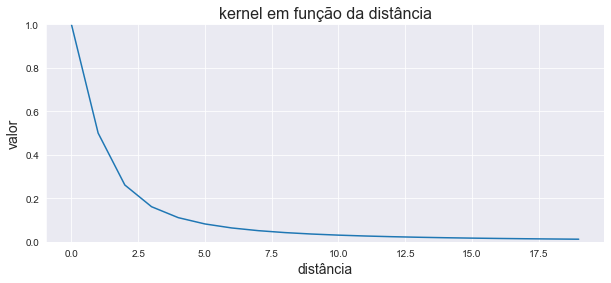

In [11]:
plt.figure(figsize=(10,4))
plt.plot(np.array(range(20)), f_kernel(np.array(range(20))))
plt.title('kernel em função da distância', fontsize=16)
plt.xlabel('distância', fontsize=14)
plt.ylabel('valor', fontsize=14)
plt.ylim(0,1)
plt.show()

### Fator de movimento de acordo com a idade

Defimos a função

- `zeta_idade`

In [12]:
def zeta_idade(a):
    return 4000.0/(4000.0 + (a-35)**2)

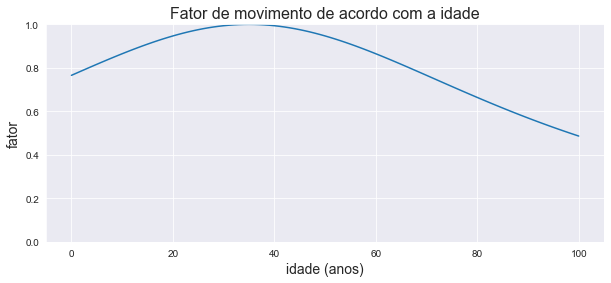

In [13]:
plt.figure(figsize=(10,4))
plt.plot(np.array(range(101)), zeta_idade(np.array(range(101))))
plt.title('Fator de movimento de acordo com a idade', fontsize=16)
plt.xlabel('idade (anos)', fontsize=14)
plt.ylabel('fator', fontsize=14)
plt.ylim(0,1)
plt.show()

### Funções de evolução dos modelos

Definimos

- `evolucao_SIR`

- `passo_modelo_individual`

- `evolucao_modelo_individual`

- `evolucao_grafo_estruturado` (versão anterior, para comparação)

In [14]:
def evolucao_SIR(pop_0, beta, gamma, tempos, plot=False):

    SIR_Compartimental = namedtuple('SIR_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'beta',
                                     'gamma',
                                     't_instantes',
                                     'S',
                                     'I', 
                                     'R',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, beta, gamma):
        S, I = X
        dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = pop_0[0:2]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, beta, gamma))
    
    resultado = SIR_Compartimental(pop_0, num_pop, beta, gamma, tempos,
                                   sol.y[0], sol.y[1], num_pop - sol.y[0] - sol.y[1], sol)
    return resultado

In [15]:
def passo_modelo_individual(pop_estado, redes, redes_tx_transmissao, pop_fator_tx_transmissao_c, 
                            prob_nao_recuperacao, pop_posicoes, f_kernel, dt):

    #
    # calcula número de indivíduos
    #
    num_pop = len(pop_estado)

    #
    # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
    #
    pop_suscetiveis = np.select([pop_estado==1], [pop_estado])

    #
    # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectado/contagioso
    #
    pop_infectados = np.select([pop_estado==2], [pop_estado])/2

    #
    # cria lista de grafos orientados para contatos com risco de contágio em cada rede
    # copia os vértices de cada rede
    # copia apenas as arestas que ligam um infectado (k) a um suscetível (i)
    #
    
    G_risco = list()
    for j in range(len(redes_tx_transmissao)):
        G_risco.append(nx.DiGraph())
        G_risco[j].add_nodes_from(redes[j].nodes())
        G_risco[j].add_edges_from([(k,i, redes[j].edges[k,i]) for (k,i) in redes[j].edges 
                            if pop_infectados[k] and pop_suscetiveis[i]])

    lambda_rate = np.array(
        [sum([redes_tx_transmissao[j][i] * G_risco[j].in_degree(i) 
              for j in range(len(redes_tx_transmissao))])
         + pop_fator_tx_transmissao_c[i] * np.dot(
             pop_infectados, f_kernel(np.linalg.norm(pop_posicoes - pop_posicoes[i], axis=1)))
         for i in range(num_pop)
        ]
    )

    prob_nao_contagio = np.exp(-dt*lambda_rate)                             

    sorteio = np.random.rand(num_pop)

    pop_novos_infectados = np.select([sorteio > prob_nao_contagio], [np.ones(num_pop)])

    sorteio = np.random.rand(num_pop)

    pop_novos_recuperados = np.select([pop_infectados * sorteio > prob_nao_recuperacao], 
                                      [np.ones(num_pop)])

    # retorna a população atualizada adicionando '1' aos que avançaram de estágio

    return pop_estado + pop_novos_infectados + pop_novos_recuperados

$$ 
  \begin{align*}
    \lambda_i^\ell & = \frac{\beta_h}{n_i^\alpha}\sum_{k; h_k = h_i}  I_k^\ell \kappa(t-\tau_k^\ell)\rho_k(1 + C_k^\ell (\omega-1)) \\
    & \quad + \frac{\beta_p^j}{{m_i^j}}\sum_{j, k; l_k^j = l_i^j} I_k^\ell \kappa(t-\tau_k^\ell)\rho_k(1 + C_k^\ell(\omega\psi_p^j(t-\tau_\kappa^\ell)-1) \\
    & \quad + \frac{\zeta(a_i)\beta_c}{\sum_j f(d_{ij})}\sum_k I_k^\ell\kappa(t-\tau_k^\ell)f(d_{ik})\rho_k(1 + C_k^\ell (\omega-1)).
  \end{align*}
$$

In [16]:
def evolucao_modelo_individual(pop_estado_0, pop_posicoes, redes, redes_tx_transmissao,
                               pop_fator_tx_transmissao_c, gamma, f_kernel,
                               dados_temporais, num_sim, show=''):
    """Evolução temporal da epidemia em um grafo estruturado.

    Entrada:
        pop_0: numpy.array
            state of the population, with 
                1: suscetível
                2: infectado
                3: recuperado ou removido

        G: numpy.array
            grafo de conexões, com atributo `taxa de transmissao`

        kernel: function
            função 'kernel' decaindo com distância entre a posição dos indivíduos

        dados_temporais: list
            [t_0, dt, num_dt]

        num_sim: int
            número de simulações

        show: str
            indica se é para exibir um gráfico e de que tipo:
                - 'nuvem': exibe uma nuvem com todas as simulações e o valor médio em destaque
                - 'sd': exibe o valor médio com uma faixa dada pelo desvio padrão
                - 'sdc': exibe o valor médio com uma faixa dada pelo desvio padrão corrigido
                - 'medio': exibe apenas o valor médio
                - '': não exibe gráfico algum.

    Saída
        X: class.SIR_Individual
            Uma instância da classe `SIR_Individual` com os seguintes atributos:
                tempos:
                num_sim:
                S_mean:
                I_mean: 
                R_mean:
                I_sigma:
                R_sigma:
                S_sigma:
    """  

    # confere se escolha para `show` é válida    
    if show:
        assert(show in ('nuvem', 'sd', 'sdc', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SIR_Individual = namedtuple('SIR_Individual', 
                                [
                                    'tempos',
                                    'S_mean',
                                    'I_mean', 
                                    'R_mean',
                                    'S_sigma',
                                    'I_sigma', 
                                    'R_sigma'
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_estado_0)
    num_inf_0 = np.count_nonzero(pop_estado_0==2)        

    # número de instantes no tempo e passos de tempo
    t_0 = dados_temporais[0]
    dt = dados_temporais[1]
    num_dt = dados_temporais[2]
    tempos = np.linspace(t_0, num_dt*dt, num_dt+1)
    
    # ajusta dados da rede dependendo se há mais de uma ou não
    #
    if type(redes) == list or type(redes_tx_transmissao) == list:
        assert(len(redes) == len(redes_tx_transmissao)), 'redes e taxas de transmissão \
        \ devem ter o mesmo número de elementos.'
    else:
        redes = [redes]
        redes_tx_transmissao = [redes_tx_transmissao]
    
    # calcula propabilidade de não recuperação
    prob_nao_recuperacao = np.exp(-dt*gamma)

    # inicializa variáveis para o cálculo da média
    S_mean = np.zeros(num_dt+1)
    I_mean = np.zeros(num_dt+1)
    R_mean = np.zeros(num_dt+1)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_dt+1)
    I_sigma = np.zeros(num_dt+1)
    R_sigma = np.zeros(num_dt+1)

    # prepara gráfico se necessário
    if show:    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha_nuvem = min(0.2, 5/num_sim)  

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        pop_estado = np.copy(pop_estado_0)
        S = np.array([num_pop - num_inf_0])
        I = np.array([num_inf_0])
        R = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for j in range(1,num_dt+1):

            pop_estado = passo_modelo_individual(pop_estado, redes, redes_tx_transmissao,
                                                 pop_fator_tx_transmissao_c, prob_nao_recuperacao,
                                                 pop_posicoes, f_kernel, dt)

            S = np.hstack([S, np.count_nonzero(pop_estado==1)])
            I = np.hstack([I, np.count_nonzero(pop_estado==2)])
            R = np.hstack([R, np.count_nonzero(pop_estado==3)])

        # adiciona as contagens dessa simulação para o cálculo final da média
        S_mean += S
        I_mean += I
        R_mean += R
        
#        S_mean = ((j-1)*S_mean + S)/j
#        I_mean = ((j-1)*I_mean + S)/j
#        R_mean = ((j-1)*R_mean + S)/j

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2
        
#        S_sigma = ((j-1)*S_sigma + S**2)/j
#        R_sigma = ((j-1)*R_sigma + S**2)/j
#        I_sigma = ((j-1)*I_sigma + S**2)/j

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha_nuvem)
            plt.plot(tempos, I, color='tab:red', alpha=alpha_nuvem)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha_nuvem)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha_nuvem)

    # divide pelo número de evoluções para obter a média
    S_mean /= num_sim
    I_mean /= num_sim
    R_mean /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_mean**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_mean**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_mean**2 )**.5

#    S_sigma = ( S_sigma - S_mean**2 )**.5
#    I_sigma = ( I_sigma - I_mean**2 )**.5
#    R_sigma = ( R_sigma - R_mean**2 )**.5

    S_sigma_cor = ( num_sim * S_sigma**2 / (num_sim - 1) )**.5
    I_sigma_cor = ( num_sim * I_sigma**2 / (num_sim - 1) )**.5
    R_sigma_cor = ( num_sim * R_sigma**2 / (num_sim - 1) )**.5


    # exibe os gráficos das médias
    if show == 'sd':
        plt.fill_between(tempos, S_mean - S_sigma, S_mean + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_sigma, I_mean + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_sigma, R_mean + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_sigma, num_pop - S_mean + S_sigma, facecolor='tab:gray', alpha = 0.2)

    if show:
        plt.plot(tempos, S_mean, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, I_mean, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_mean, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, num_pop - S_mean, '-', color='tab:gray', label='inf.+ rec.')
        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show:
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SIR_Individual(
        tempos,
        S_mean,
        I_mean, 
        R_mean,
        I_sigma,
        R_sigma,
        S_sigma
    )

    return resultado

In [17]:
def evolucao_grafo_estruturado(pop_0, G, gamma, tempos, num_sim, show=''):
    """Evolução temporal da epidemia em um grafo estruturado.


    Entrada:
        pop_0: numpy.array
            state of the population, with 
                1: suscetível
                2: infectado
                3: recuperado ou removido

        G: numpy.array
            grafo de conexões, com atributo `taxa de transmissao`

        gamma: float
            taxa de recuperação por unidade de tempo

        tempos: numpy.array
            instantes de tempo

        num_sim: int
            número de simulações

        show: str
            indica se é para exibir um gráfico e de que tipo:
                - 'nuvem': exibe uma nuvem com todas as simulações e o valor médio em destaque
                - 'sd': exibe o valor médio com uma faixa dada pelo desvio padrão
                - 'sdc': exibe o valor médio com uma faixa dada pelo desvio padrão corrigido
                - '68%': exibe o valor médio com uma faixa dada pelo intervalo de confiança de 68%
                - '95%': exibe o valor médio com uma faixa dada pelo intervalo de confiança de 95%
                - 'medio': exibe apenas o valor médio
                - '': não exibe gráfico algum.

    Saída
        X: class.SIR_Individual
            Uma instância da classe `SIR_Individual` com os seguintes atributos:
                pop_0:
                num_pop:
                tau:
                gamma:
                G:
                tempos:
                num_sim:
                S_mean:
                I_mean: 
                R_mean:
                I_sigma:
                R_sigma:
                S_sigma:
    """

    def passo_grafo_estruturado(num_pop, populacao, T_prob_nao_infeccao, prob_nao_recuperacao):
        
        # gera uma matriz cheia aleatória (números em [0.0,1.0))
        A_random = np.random.rand(num_pop, num_pop)
        
        # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
        pop_suscetiveis = np.select([populacao==1], [populacao])
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectado/contagioso
        pop_infectados = np.select([populacao==2], [populacao])/2
        
        # cria uma matriz aleatória de risco, mantendo apenas as conexões que envolvem infectados
        A_risco_random = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_random)
        
        # filtra a matriz aleatória mantendo apenas os contatos entre um suscetível e um infectado
        A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco_random)
        
        # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
        A_infectados = np.select([A_contatos > T_prob_nao_infeccao], [np.ones([num_pop, num_pop])])

        # obtém novos infectados
        pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_pop)])
        
        # filtra matriz aleatória com a diagonal
        pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)
        
        # obtém novos recuperados
        pop_novos_recuperados = np.select([pop_recuperando > prob_nao_recuperacao], [np.ones(num_pop)])
        
        # atualiza população adicionando um aos que avançaram de estágio
        populacao_nova = populacao + pop_novos_infectados + pop_novos_recuperados

        # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
        # a independência desses eventos aleatórios (tanto quanto se leve em consideração
        # que os números gerados são pseudo-aleatórios)

        return populacao_nova

    
    # confere se escolha para `show` é válida
    if show:
        assert(show in ('nuvem', 'sd', '68%', '95%', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SIR_Individual = namedtuple('SIR_Individual', 
                                [
                                    'pop_0',
                                    'num_pop',
                                    'G',
                                    'gamma',
                                    'tempos',
                                    'num_sim',
                                    'S_mean',
                                    'I_mean', 
                                    'R_mean',
                                    'S_sigma',
                                    'I_sigma', 
                                    'R_sigma',
                                    'S_erro_padrao',
                                    'I_erro_padrao', 
                                    'R_erro_padrao'
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_0)
    I_0 = np.count_nonzero(pop_0==2)        

    # número de instantes no tempo e passos de tempo 
    num_t = len(tempos)
    passos_de_tempo = tempos[1:] - tempos[:-1]

    # inicializa variáveis para o cálculo da média
    S_mean = np.zeros(num_t)
    I_mean = np.zeros(num_t)
    R_mean = np.zeros(num_t)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_t)
    I_sigma = np.zeros(num_t)
    R_sigma = np.zeros(num_t)
    
    # obtém matriz de adjacências e o número médio de vizinhos do grafo
    T_adj = nx.to_numpy_matrix(G, weight = 'taxa de transmissao')

    # prepara gráfico se necessário
    if show:    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha = min(0.2, 5/num_sim)    

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        populacao = np.copy(pop_0)
        S = np.array([num_pop - I_0])
        I = np.array([I_0])
        R = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for dt in passos_de_tempo:

            # calcula probabilidades
            T_prob_nao_infeccao = np.exp(-dt*T_adj)
            prob_nao_recuperacao = np.exp(-gamma*dt)

            populacao = passo_grafo_estruturado(num_pop, populacao,
                                                T_prob_nao_infeccao, prob_nao_recuperacao)
            S = np.hstack([S, np.count_nonzero(populacao==1)])
            I = np.hstack([I, np.count_nonzero(populacao==2)])
            R = np.hstack([R, np.count_nonzero(populacao==3)])
            
        # adiciona as contagens dessa simulação para o cálculo final da média
        S_mean += S
        I_mean += I
        R_mean += R

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha)
            plt.plot(tempos, I, color='tab:red', alpha=alpha)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha)

    # divide pelo número de evoluções para obter a média
    S_mean /= num_sim
    I_mean /= num_sim
    R_mean /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_mean**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_mean**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_mean**2 )**.5
    
    S_sigma_cor = ( num_sim * S_sigma**2 / (num_sim - 1) )**.5
    I_sigma_cor = ( num_sim * I_sigma**2 / (num_sim - 1) )**.5
    R_sigma_cor = ( num_sim * R_sigma**2 / (num_sim - 1) )**.5
    
    S_erro_padrao = S_sigma_cor / num_sim**.5
    I_erro_padrao = I_sigma_cor / num_sim**.5
    R_erro_padrao = R_sigma_cor / num_sim**.5

    # exibe os gráficos das médias
    if show == 'sd':
        plt.fill_between(tempos, S_mean - S_sigma, S_mean + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_sigma, I_mean + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_sigma, R_mean + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_sigma, num_pop - S_mean + S_sigma, facecolor='tab:gray', alpha = 0.2)
        
    if show == '68%':
        plt.fill_between(tempos, S_mean - S_erro_padrao, S_mean + S_erro_padrao, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - I_erro_padrao, I_mean + I_erro_padrao, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - R_erro_padrao, R_mean + R_erro_padrao, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - S_erro_padrao, num_pop - S_mean + S_erro_padrao, facecolor='tab:gray', alpha = 0.2)

    if show == '95%':
        plt.fill_between(tempos, S_mean - 2*S_erro_padrao, S_mean + 2*S_erro_padrao, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_mean - 2*I_erro_padrao, I_mean + 2*I_erro_padrao, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_mean - 2*R_erro_padrao, R_mean + 2*R_erro_padrao, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_mean - 2*S_erro_padrao, num_pop - S_mean + 2*S_erro_padrao, facecolor='tab:gray', alpha = 0.2)

    if show:
        plt.plot(tempos, S_mean, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, I_mean, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_mean, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, num_pop - S_mean, '-', color='tab:gray', label='inf.+ rec.')
        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == '68%':
        plt.title('Evolução da média, com intervalo de confiança de 68%', fontsize=16)
    elif show == '95%':
        plt.title('Evolução da média, com intervalo de confiança de 95%', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show:
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SIR_Individual(
        pop_0,
        num_pop,
        G,
        gamma,
        tempos,
        num_sim,
        S_mean,
        I_mean, 
        R_mean,
        I_sigma,
        R_sigma,
        S_sigma,
        S_erro_padrao,
        I_erro_padrao, 
        R_erro_padrao
    )

    return resultado

## Construindo as camadas de redes de conexão

- Posicionamento

- Rede de residências.

- Rede social (escola e trabalho).

- Rede global (usada apenas no modelo anterior, para comparação).

### Posicionamento

Construimos essa rede com os seguintes passos:

1. Dividimos o espaço em áreas retangulares.

2. Definimos a população em cada área dessas.

3. Posicionamos os indivíduos, aleatoriamente, em cada área correspondente, de acordo com a população em cada área dessas.

4. Essas posições vão para uma variável do tipo `dict`, onde a chave é o número do indivíduo/vértice e o valor é uma `tuple` com as duas coordenadas espaciais de cada indivíduo.

5. Finalmente, criamos a rede com a função [nx.random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html). Outra opção é [nx.thresholded_random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.thresholded_random_geometric_graph.html), que é equivalente ao anterior quando o seu argumento `theta` daquele é igual a 0, exceto que ela ainda confere um "peso" ao vértice.

6. Essa rede faz conexões segundo a proximididade e uma certa probabilidade ocorrência.

#### Habitantes por área

Primeiro, definimos a matriz representando o número de habitantes por "bairro", ou, mais precisamente, área retângular.

In [18]:
densidade = np.array(
    [[16, 11, 0, 0,  0,  6,  4,  8,  8,  6],
     [10, 12, 12, 6, 8, 9,  8,  6,  7,  5],
     [0, 10, 14, 10, 12,  8,  0,  0,  6,  8],
     [0, 12, 10, 14, 11,  9,  0,  0,  5,  7],
     [9, 11, 0, 12, 10,  7,  8,  7,  8, 0]
    ])
densidade.shape[1]

10

**Visualização da matriz:**

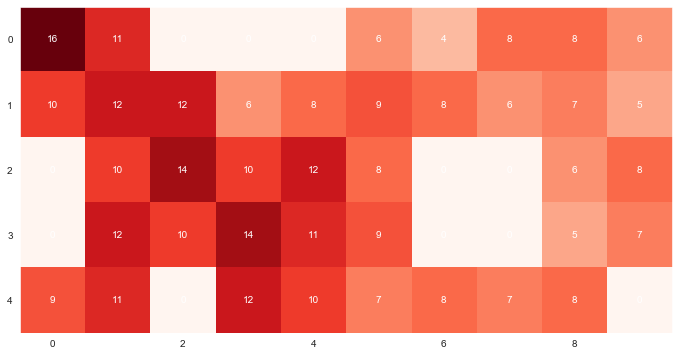

In [19]:
plt.figure(figsize=(12,6))
plt.imshow(densidade, cmap='Reds', interpolation='nearest')
for i in range(densidade.shape[0]):
    for j in range(densidade.shape[1]):
        plt.text(j, i, densidade[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.show()

#### Distribuição da população

Em seguida, distribuímos os habitantes aleatoriamente segundo a divisão populacional por área retangular.

In [20]:
np.random.seed(seed = 127)
attr_pos = dict()
k = 0
N, M = densidade.shape
for m in range(M):
    for n in range(N):
        for i in range(densidade[n,m]):
            attr_pos.update({k: [m + np.random.rand(), N - n + np.random.rand()]})
            k += 1
pop_posicoes = np.array(list(attr_pos.values()))
num_pop = len(pop_posicoes)

#### Estado inicial da população

Com base nessa população inicial, definimos quantos e quais indivíduos estão infectados.

Dessa vez, vamos definir um `numpy.array` de tipo `uint8`, ou seja, inteiro de 8 bits sem sinal, que pode assumir valores inteiros entre 0 a 255.

Lembrando a interpretação com base no modelo SIR:

- `1`: suscetível;

- `2`: infectado;

- `3`: recuperado ou removido.

In [21]:
# estado inicial da população
np.random.seed(seed = 342)
#pop_estado_0 = np.ones(num_pop, dtype=np.uint8)
pop_estado_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, num_infectados_0, replace=False)
#pop_estado_0[infectados_0] = 2*np.ones(num_inf_0, dtype=np.uint8)
pop_estado_0[infectados_0] = 2*np.ones(num_infectados_0)

#### Idade dos indivíduos

Também definimos a idade de cada indivíduo.

Nesse momento, isso é feito apenas com base na pirâmide etária do Brasil. 

Posteriormente, o ideal é nos basearmos, também, na distribuição etária em função do tamanho das residências.

Dados da [pirâmide etária do Brasil do senso de 2010](https://censo2010.ibge.gov.br/sinopse/webservice/frm_piramide.php) nos dão a seguinte distribuição:

In [22]:
censo_5 = {'0 a 4 anos': [7016987, 6779172],
           '5 a 9 anos': [7624144, 7345231],
           '10 a 14 anos': [8725413, 8441348],
           '15 a 19 anos': [8558868, 8432002],
           '20 a 24 anos': [8630227, 8614963],
           '25 a 29 anos': [8460995, 8643418],
           '30 a 34 anos': [7717657, 8026855],
           '35 a 39 anos': [6766665, 7121916],
           '40 a 44 anos': [6320570, 6688797],
           '45 a 49 anos': [5692013, 6141338],
           '50 a 54 anos': [4834995, 5305407],
           '55 a 59 anos': [3902344, 4373875],
           '60 a 64 anos': [3041034, 3468085],
           '65 a 69 anos': [2224065, 2616745],
           '70 a 74 anos': [1667373, 2074264],
           '75 a 79 anos': [1090518, 1472930],
           '80 a 84 anos': [668623, 998349],
           '85 a 89 anos': [310759, 508724],
           '90 a 94 anos': [114964, 211595],
           '95 a 99 anos': [31529, 66806],
           'Mais de 100 anos': [7247, 16989]
          }

In [23]:
censo_parciais = [a + b for a,b in list(censo_5.values())]
censo_10 = {'0 a 9 anos': sum(censo_parciais[0:2]),
            '10 a 19 anos': sum(censo_parciais[2:4]),
            '20 a 29 anos': sum(censo_parciais[4:6]),
            '30 a 39 anos': sum(censo_parciais[6:8]),
            '40 a 49 anos': sum(censo_parciais[8:10]),
            '50 a 59 anos': sum(censo_parciais[10:12]),
            '60 a 69 anos': sum(censo_parciais[12:14]),
            '70 a 79 anos': sum(censo_parciais[14:16]),
            '80 ou mais anos': sum(censo_parciais[16:])
           }

In [24]:
censo_total = sum(censo_parciais)
censo_fracoes = {k:v/censo_total for k, v in censo_10.items()}

In [25]:
for k, v in censo_fracoes.items():
    print(f'{k}: {100*v:.1f}%')

0 a 9 anos: 15.1%
10 a 19 anos: 17.9%
20 a 29 anos: 18.0%
30 a 39 anos: 15.5%
40 a 49 anos: 13.0%
50 a 59 anos: 9.7%
60 a 69 anos: 5.9%
70 a 79 anos: 3.3%
80 ou mais anos: 1.5%


Sorteando as idades

In [26]:
populacao_idades = np.random.choice(9, num_pop, p=list(censo_fracoes.values())).astype(np.uint8)

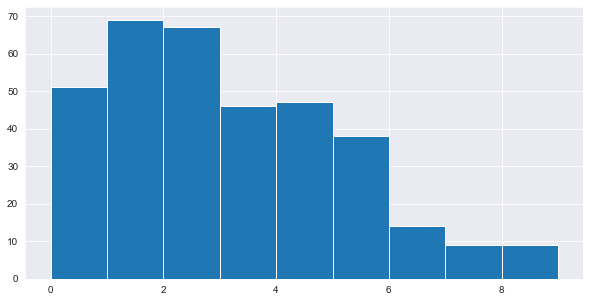

In [27]:
plt.figure(figsize=(10,5))
plt.hist(populacao_idades, bins=9, range=(0,9))
plt.show()

#### Construção da rede residencial

Finalmente, construimos a rede.

In [28]:
G_r = nx.random_geometric_graph(num_pop, 0.2, pos=attr_pos, seed=1327)
G_r = nx.random_geometric_graph(num_pop, 0.6, pos=attr_pos, seed=1327)
#G_r = nx.thresholded_random_geometric_graph(num_pop, 0.2, theta = 0.05, pos=attr_pos, seed=1727)

#attr_estado_0 = dict([(i, {'estado': pop_estado_0[i]}) for i in range(num_pop)])
attr_estado_0 = dict([(i, {'estado': int(pop_estado_0[i])}) for i in range(num_pop)])
#attr_idades = dict([(i, {'faixa etária': populacao_idades[i]}) for i in range(num_pop)])
nx.set_node_attributes(G_r, attr_estado_0)
#nx.set_node_attributes(G_r, attr_idades)
rho_forma = 0.2
rho_escala = 5
rho = np.random.gamma(rho_forma, rho_escala, num_pop) # shape 0.2 and scale 5 for a mean value of 0.2*5 = 1
#nx.set_node_attributes(G_r, dict([(i, {'rho': rho[i]}) for i in range(num_pop)]))

nx.set_edge_attributes(G_r, 1, 'weight')

pop_tx_transmissao_r = np.array([beta_r / (1+G_r.degree(i))**alpha for i in G_r.nodes])
attr_transmissao_r = dict([(i, {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}) 
                           for i in G_r.nodes])
nx.set_node_attributes(G_r, attr_transmissao_r)

### Termo de fator de contágio

Definimos, aqui, os valores do termo $\rho_i$.

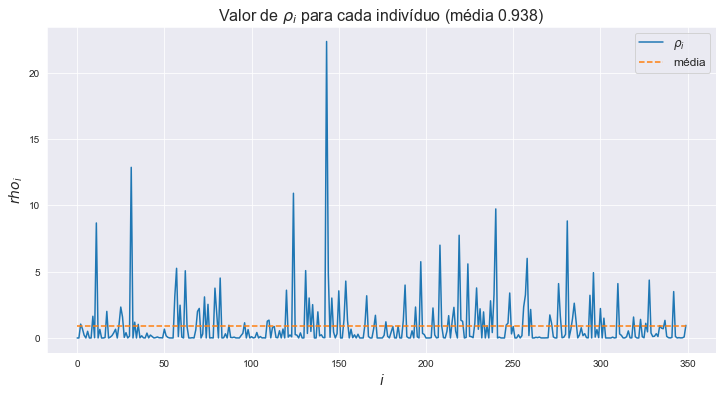

In [29]:
plt.figure(figsize=(12,6))
plt.plot(rho, label=r'$\rho_i$')
plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$rho_i$', fontsize=14)
#plt.yscale('log')
plt.legend(fontsize=12)
plt.title(r'Valor de $\rho_i$ para cada indivíduo (média {:.3f})'.format(np.mean(rho)), fontsize=16)
plt.show()

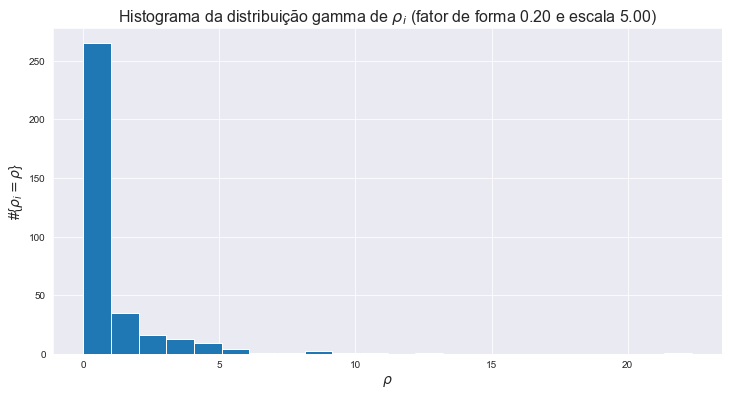

In [30]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=22)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'#{$\rho_i=\rho$}', fontsize=14)
#plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$ (fator de forma {:.2f} e escala {:.2f})'.format(rho_forma, rho_escala), fontsize=16)
plt.show()

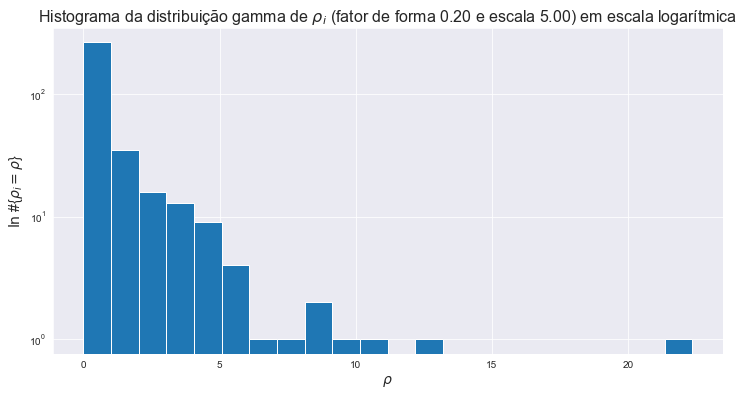

In [31]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=22)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\ln$ #{$\rho_i=\rho$}', fontsize=14)
plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$ (fator de forma {:.2f} e escala {:.2f}) em escala logarítmica'.format(rho_forma, rho_escala), fontsize=16)
plt.show()

#### Análise da rede

Memória utilizada pelo grafo: 30.1 Kb
Memória utilizada pela matriz de adjacências: 957.1 Kb
Número de vértices: 350
Número de arestas: 1536
Número de arestas com peso: 1536.0
Número médio de conexões por indivíduo: 8.8
Número médio de conexões por indivíduo com peso: 8.8


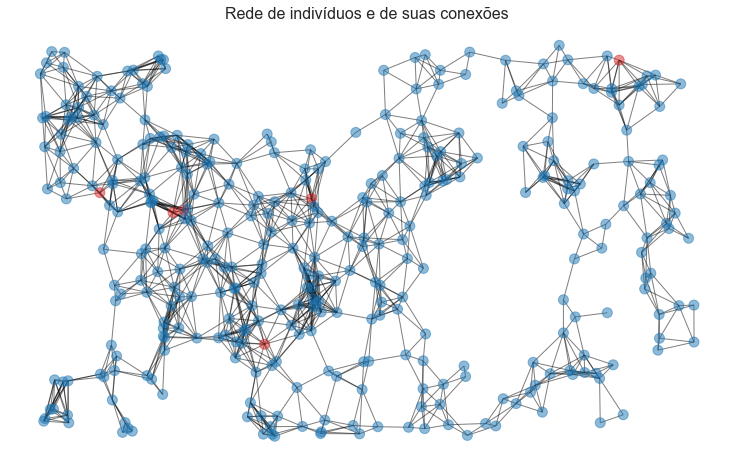

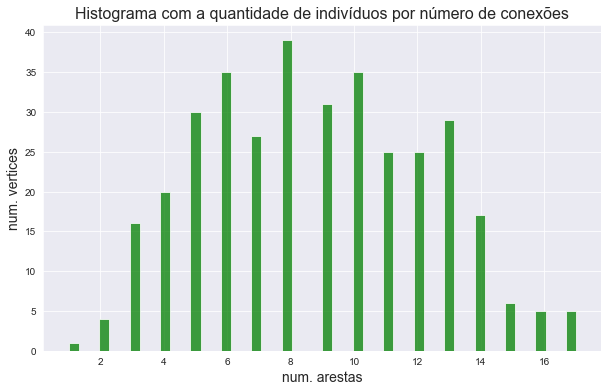

In [32]:
num_medio_conexoes_r = analise_grafo(G_r, info=True, node_size=100, pos=attr_pos, hist=True)

### Rede global

Agora, construímos uma rede completa, usando a localização dos indivíduos feita na construção do grafo geométrico, mas com conexões com peso decaindo de acordo com a distância entre os indivíduos.

In [33]:
G_c = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_c, attr_estado_0)

dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))
#
# kernel function from Keeling & Rohani (2007)
# kernel = lambda d: d**-2.6
#
# kernel function from Ferguson et al (2005), but with different parameter values
a = 1 #
b = 1.5 #
kernel = lambda d: 1.0/(1.0 + (d/a)**b)
#
attr_kernel_dist = [(i, j, 
                     {'weight': kernel(dist(attr_pos[i], attr_pos[j]))}) 
                    for i in range(num_pop) 
                    for j in range(num_pop) if j != i]

G_c.add_edges_from(attr_kernel_dist)

attr_transmissao = {(i, j): 
                    {'taxa de transmissao': beta_c * G_c.edges[i,j]['weight']/ G_c.degree(i, weight='weight')}
                    for (i,j) in G_c.edges()
                   }

aux = np.array([np.sum(f_kernel(np.linalg.norm(pop_posicoes - pop_posicoes[i], axis=1))) for i in range(num_pop)])
#aux = G_c.size(weight='weight')
#aux = np.array((G_c.degree(i, weight='weight') for i in range(num_pop)))
pop_fator_tx_transmissao_c = beta_c * zeta_idade(populacao_idades) / aux

nx.set_edge_attributes(G_c, attr_transmissao)

#### Análise da rede

Memória utilizada pelo grafo: 495.3 Kb
Memória utilizada pela matriz de adjacências: 957.1 Kb
Número de vértices: 350
Número de arestas: 61075
Número de arestas com peso: 9027.576708599296
Número médio de conexões por indivíduo: 51.6
Número médio de conexões por indivíduo com peso: 51.6


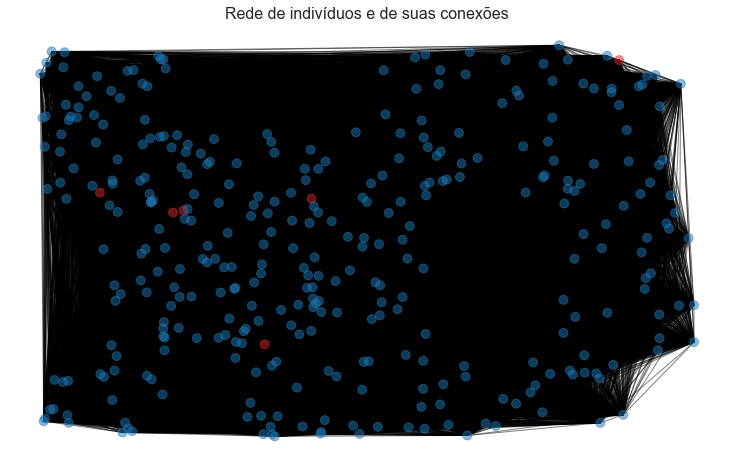

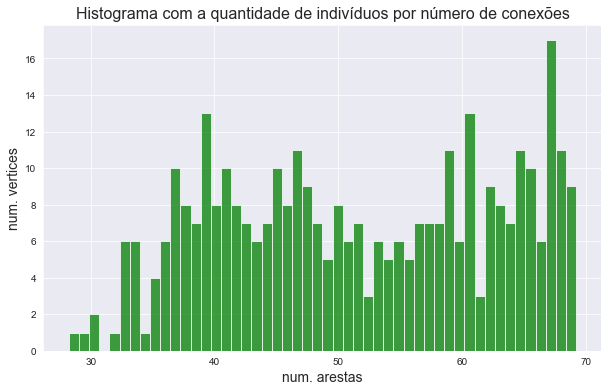

In [34]:
num_medio_conexoes_c = analise_grafo(G_c, info=True, node_size=80, pos=attr_pos, hist=True)

### Rede social (escola e trabalho)

- Lugares de trabalho e escolas têm a propriedade de congregar diversos indivíduos.

- Simulamos isso selecionando indivíduos aleatoriamento e conectando todos entre si.

- É claro que indivíduos em um mesmo local de trabalho ou escola tendem a formar grupos, com elos mais fortes, mas isso não é levado em consideração.

- Diferentes trabalhos também acarretam em conexões entre alguns de seus indivíduos, mas isso também não é implementado no modelo do Imperial College.|

- Naturalmente, nem todos participam de grupos assim (e.g. bebês, desempregados, aposentados), então nem todos serão selecionados neste processo.

- Posteriormente, dividiremos os locais entre escola e trabalho, mas agora vamos trabalhar com uma rede só.

#### Tamanho dos lugares

Em [Ferguson et al (2005)](#Referências), é mencionado que o tamanho, em número de trabalhadores, dos lugares de trabalho também satisfaz uma lei de potência.

Aqui, não vamos nos preocupar muito com a forma exata dessa distribuição.

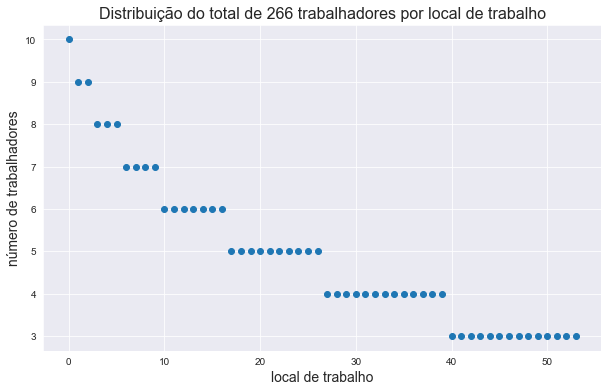

In [35]:
rs_tamanho = [10, 9, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
           5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
#print('Total de indivíduos nos lugares de trabalho/escola:', )
plt.figure(figsize=(10,6))
plt.plot(rs_tamanho, 'o')
plt.xlabel('local de trabalho', fontsize=14)
plt.ylabel('número de trabalhadores', fontsize=14)
plt.title(f'Distribuição do total de {sum(rs_tamanho)} trabalhadores por local de trabalho', fontsize=16)
plt.show()

#### Construção da rede

In [36]:
G_s = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_s, attr_estado_0)
random.seed(721)
pop_index = list(range(num_pop))
membros = dict()

for j in range(len(rs_tamanho)):
    individuos_aleatorios = random.sample(pop_index, rs_tamanho[j])
    for i in individuos_aleatorios:
        pop_index.remove(i)
    membros.update({j: individuos_aleatorios})
    conexoes = [(m,n) for m in individuos_aleatorios for n in individuos_aleatorios if m != n ]
    G_s.add_edges_from(conexoes)

nx.set_edge_attributes(G_s, 1, 'weight')

pop_tx_transmissao_s = np.array([beta_s / (1+G_s.degree(i)) for i in G_s.nodes])
attr_transmissao_s = dict([(i, {'taxa de transmissao': beta_s / (1+G_s.degree(i))}) 
                           for i in G_s.nodes])

nx.set_node_attributes(G_s, attr_transmissao_s)

#### Análise da rede

Memória utilizada pelo grafo: 22.9 Kb
Memória utilizada pela matriz de adjacências: 957.1 Kb
Número de vértices: 350
Número de arestas: 610
Número de arestas com peso: 610.0
Número médio de conexões por indivíduo: 3.5
Número médio de conexões por indivíduo com peso: 3.5


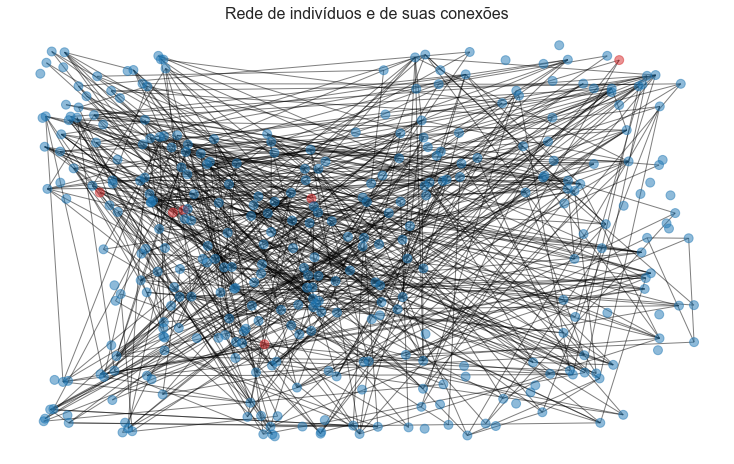

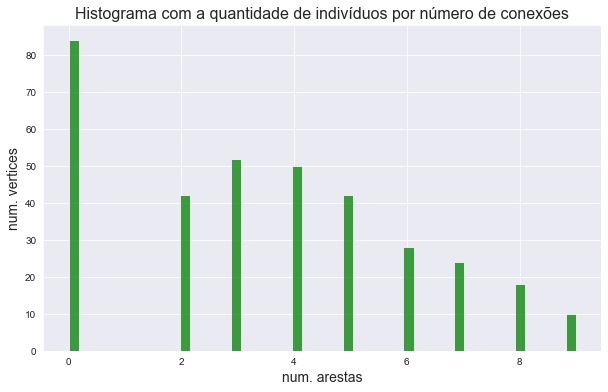

In [37]:
num_medio_conexoes_s = analise_grafo(G_s, info=True, node_size=80, pos=attr_pos, hist=True)

## Juntando as redes residencial e de escola/trabalho

Memória utilizada pelo grafo: 34.8 Kb
Memória utilizada pela matriz de adjacências: 957.1 Kb
Número de vértices: 350
Número de arestas: 2132
Número de arestas com peso: 2132.0
Número médio de conexões por indivíduo: 12.2
Número médio de conexões por indivíduo com peso: 12.2


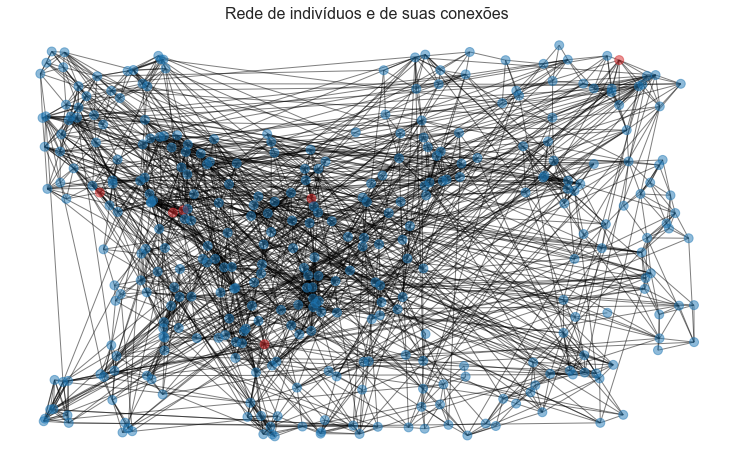

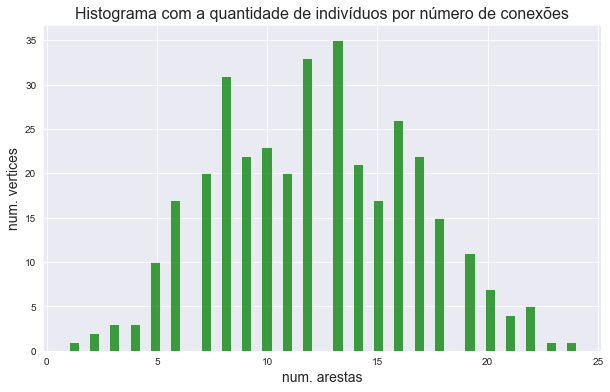

In [38]:
G_rs = nx.compose(G_s, G_r)
pop_tx_transmissao_rs_sum = pop_tx_transmissao_r + pop_tx_transmissao_s
num_medio_conexoes_rs = analise_grafo(G_rs, info=True, node_size=80, pos=attr_pos, hist=True)

### Evolução da rede combinada

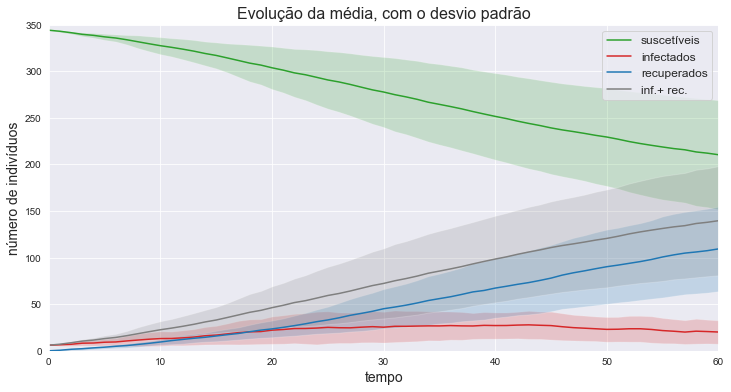

CPU times: user 33.1 s, sys: 260 ms, total: 33.4 s
Wall time: 34.4 s


In [39]:
%%time
redes_rs = [G_r, G_s]
redes_tx_transmissao_rs = [pop_tx_transmissao_r, pop_tx_transmissao_s]
X_rs = evolucao_modelo_individual(pop_estado_0, pop_posicoes, redes_rs, redes_tx_transmissao_rs,
                                  pop_fator_tx_transmissao_c, gamma, f_kernel,
                                  dados_temporais, num_sim, show='sd')

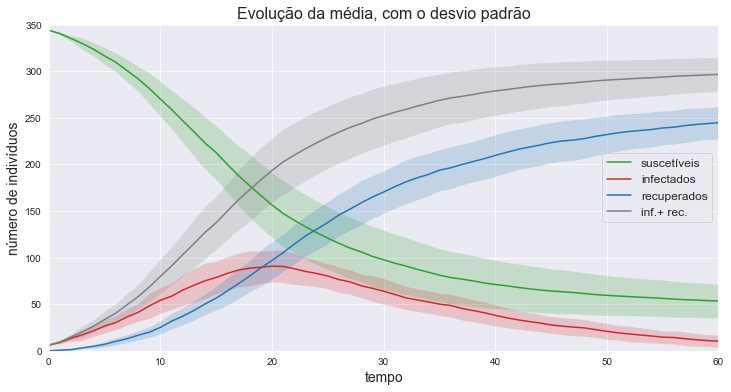

CPU times: user 31.1 s, sys: 312 ms, total: 31.5 s
Wall time: 32.5 s


In [40]:
%%time
X_rs_sum = evolucao_modelo_individual(pop_estado_0, pop_posicoes, G_rs, pop_tx_transmissao_rs_sum,
                                      pop_fator_tx_transmissao_c, gamma, f_kernel,
                                      dados_temporais, num_sim, show='sd')

### Comparando com o modelo anterior

In [41]:
attr_transmissao_edge_r = {(i, j): 
                           {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}
                           for (i,j) in G_r.edges()}

attr_transmissao_edge_s = {(i, j): 
                           {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
                           for (i,j) in G_s.edges()}

nx.set_edge_attributes(G_r, attr_transmissao_edge_r)

nx.set_edge_attributes(G_s, attr_transmissao_edge_s)

G_rs_old = nx.compose(G_s, G_r)

for (u, v, w) in G_rs_old.edges.data('taxa de transmissao', default=0):
    if (u, v) in G_s.edges and (u,v) in G_r.edges:
        G_rs_old.edges[u, v]['taxa de transmissao'] = \
            G_r.edges[u,v]['taxa de transmissao'] + G_s.edges[u,v]['taxa de transmissao']

#num_medio_conexoes_rs_ols = analise_grafo(G_rs_old, info=True, node_size=80, pos=attr_pos, hist=True)

Redes residencial e social


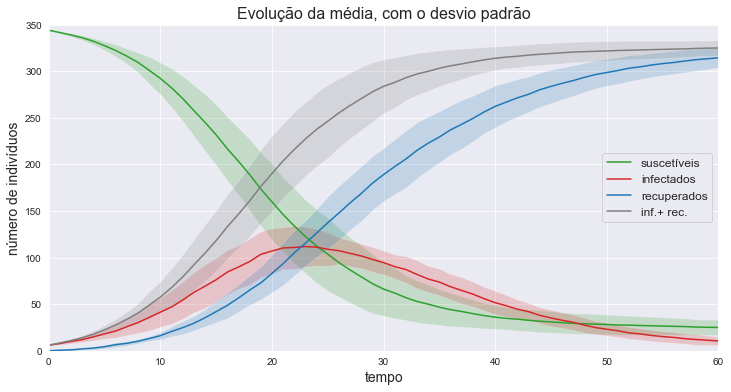

CPU times: user 14 s, sys: 1.46 s, total: 15.5 s
Wall time: 8.68 s


In [42]:
%%time
print('Redes residencial e social')
X_rs_old = evolucao_grafo_estruturado(pop_estado_0, G_rs_old, gamma, tempos, num_sim, show='sd')

In [43]:
attr_transmissao_edge_r = {(i, j): 
                           {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}
                           for i in G_r.nodes for j in G_r.nodes}

attr_transmissao_edge_r = {(i, j):
                           {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}
                           for (i,j) in G_r.edges()
                          }

attr_transmissao_edge_s = {(i, j): 
                           {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
                           for i in G_s.nodes for j in G_s.nodes
                          }

attr_transmissao_edge_s = {(i, j):
                           {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
                           for (i,j) in G_s.edges()
                          }

G_r_old = G_r.copy()
G_s_old = G_s.copy()

nx.set_edge_attributes(G_r_old, attr_transmissao_edge_r)

nx.set_edge_attributes(G_s_old, attr_transmissao_edge_s)

G_rs_old = nx.compose(G_s_old, G_r_old)

for (u, v, w) in G_rs_old.edges.data('taxa de transmissao', default=0):
    if (u, v) in G_s_old.edges and (u,v) in G_r.edges:
        G_rs_old.edges[u, v]['taxa de transmissao'] = \
            G_r_old.edges[u,v]['taxa de transmissao'] + G_s_old.edges[u,v]['taxa de transmissao']
        
G_a_old = nx.compose_all([G_c, G_s_old, G_r_old])

for (u, v, w) in G_c.edges.data('taxa de transmissao', default=0):
    G_a_old.edges[u,v]['taxa de transmissao'] = G_c.edges[u,v]['taxa de transmissao']
    if (u, v) in G_s.edges:
        G_a_old.edges[u, v]['taxa de transmissao'] += G_s_old.edges[u,v]['taxa de transmissao']
    if (u, v) in G_r.edges:
        G_a_old.edges[u, v]['taxa de transmissao'] += G_r_old.edges[u,v]['taxa de transmissao']

Redes residencial e social


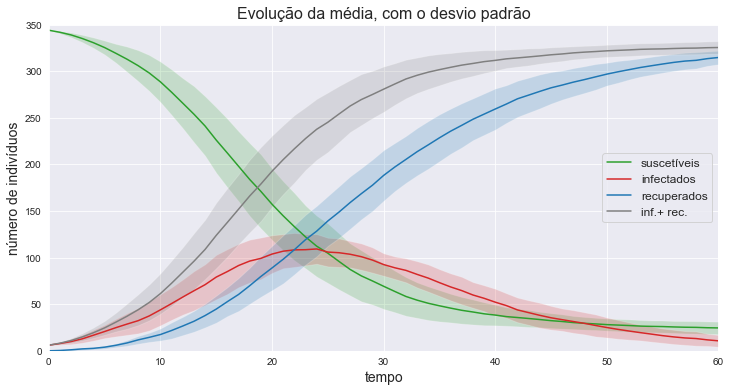

CPU times: user 12.6 s, sys: 655 ms, total: 13.3 s
Wall time: 7.05 s


In [44]:
%%time
print('Redes residencial e social')
X_rs_old = evolucao_grafo_estruturado(pop_estado_0, G_rs_old, gamma, tempos, num_sim, show='sd')

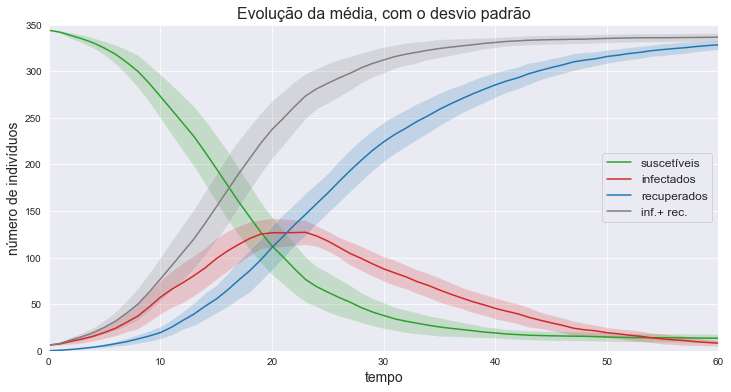

CPU times: user 12.4 s, sys: 152 ms, total: 12.5 s
Wall time: 6.55 s


In [45]:
%%time
X_a_old = evolucao_grafo_estruturado(pop_estado_0, G_a_old, gamma, tempos, num_sim, show='sd')

### Comparação com o SIR compartimental

In [46]:
X = evolucao_SIR(pop_0 = [num_pop-num_infectados_0, num_infectados_0, 0], beta=beta, gamma=gamma, tempos = tempos)

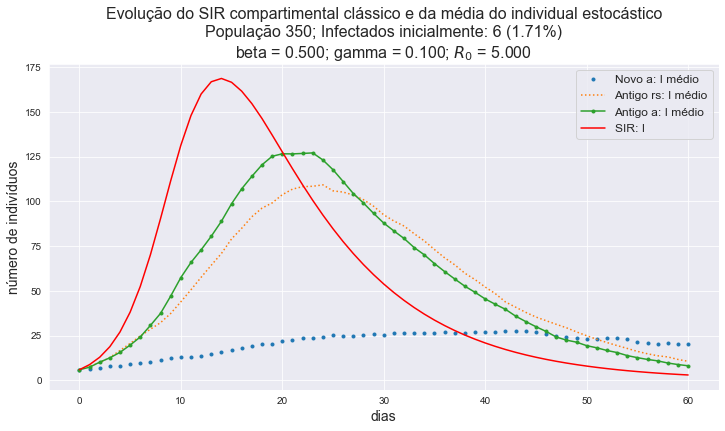

In [47]:
plt.figure(figsize=(12,6))
#plt.ylim(0, num_pop/2)

# exibe os gráficos das médias
plt.plot(tempos, X_rs.I_mean, '.', label='Novo a: I médio')
#plt.plot(tempos, X_rs_sum.I_mean, 'o-', label='I_sum médio')
plt.plot(tempos, X_rs_old.I_mean, ':', label='Antigo rs: I médio')
plt.plot(tempos, X_a_old.I_mean, '.-', label='Antigo a: I médio')
plt.plot(tempos, X.I, 'red', label='SIR: I')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental clássico e da média do individual estocástico\n'
          + f'População {num_pop}; Infectados inicialmente: {num_infectados_0} ({100*num_infectados_0/num_pop:.2f}%)\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Debug

### A small network

In [48]:
num_sim = 20
beta_r = 3
beta_s = 3
gamma = 2

In [49]:
# densidade populacional
densidade = np.array(
    [[4, 2],
     [2, 0]
    ])


# posições
np.random.seed(seed = 127)
attr_pos = dict()
k = 0
N, M = densidade.shape
for m in range(M):
    for n in range(N):
        for i in range(densidade[n,m]):
            attr_pos.update({k: [m + np.random.rand(), N - n + np.random.rand()]})
            k += 1
pop_posicoes = np.array(list(attr_pos.values()))

num_pop = len(pop_posicoes)
num_infectados_0 = 2

# estado inicial da população
np.random.seed(seed = 342)
pop_estado_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, num_infectados_0, replace=False)
pop_estado_0[infectados_0] = 2*np.ones(num_infectados_0)

populacao_idades = np.random.choice(9, num_pop, p=list(censo_fracoes.values())).astype(np.uint8)

pop_estado_0

array([2., 2., 1., 1., 1., 1., 1., 1.])

Memória utilizada pelo grafo: 448.0 byte(s)
Memória utilizada pela matriz de adjacências: 624.0 byte(s)
Número de vértices: 8
Número de arestas: 4
Número de arestas com peso: 4.0
Número médio de conexões por indivíduo: 1.0
Número médio de conexões por indivíduo com peso: 1.0


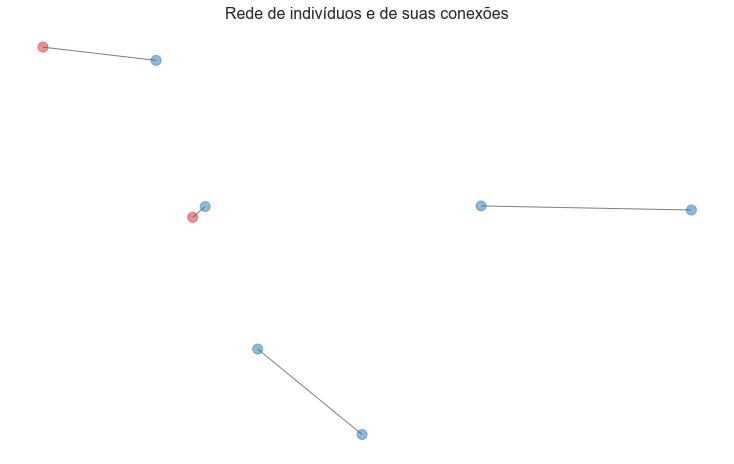

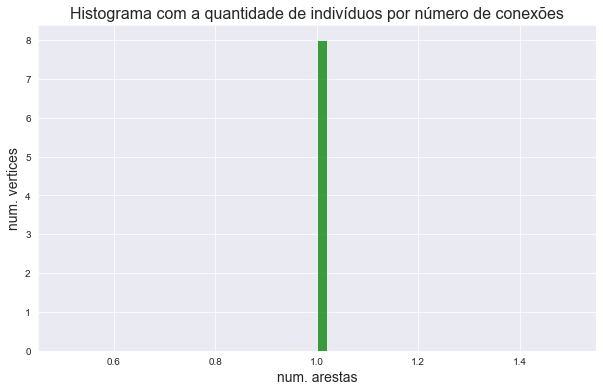

In [50]:
# rede residencial
G_r = nx.random_geometric_graph(num_pop, 0.5, pos=attr_pos, seed=1327)

attr_estado_0 = dict([(i, {'estado': int(pop_estado_0[i])}) for i in range(num_pop)])
nx.set_node_attributes(G_r, attr_estado_0)
rho_forma = 0.2
rho_escala = 5
rho = np.random.gamma(rho_forma, rho_escala, num_pop) # shape 0.2 and scale 5 for a mean value of 0.2*5 = 1

nx.set_edge_attributes(G_r, 1, 'weight')

pop_tx_transmissao_r = np.array([beta_r / (1+G_r.degree(i))**alpha for i in G_r.nodes])
attr_transmissao_r = dict([(i, {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}) 
                           for i in G_r.nodes])
nx.set_node_attributes(G_r, attr_transmissao_r)

num_medio_conexoes_r = analise_grafo(G_r, info=True, node_size=100, pos=attr_pos, hist=True)

In [51]:
G_r.edges()

EdgeView([(0, 2), (1, 3), (4, 5), (6, 7)])

In [52]:
nx.to_numpy_array(G_r)

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

Memória utilizada pelo grafo: 464.0 byte(s)
Memória utilizada pela matriz de adjacências: 624.0 byte(s)
Número de vértices: 8
Número de arestas: 6
Número de arestas com peso: 6.0
Número médio de conexões por indivíduo: 1.5
Número médio de conexões por indivíduo com peso: 1.5


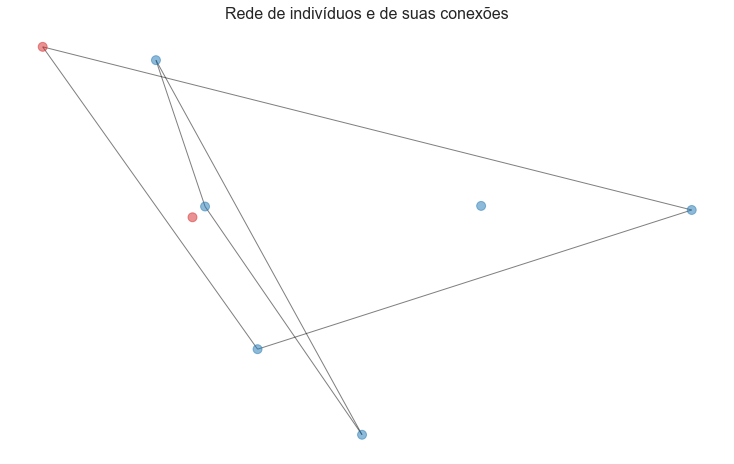

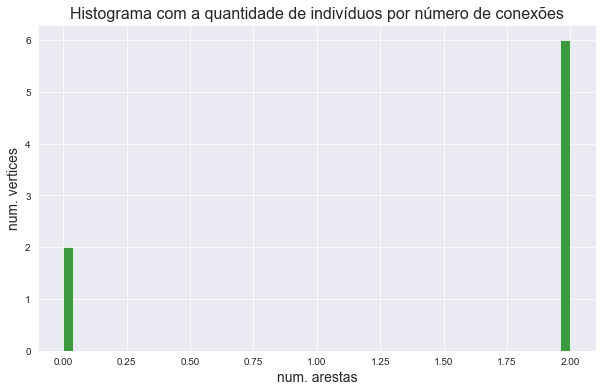

In [53]:
G_s = nx.random_geometric_graph(num_pop, 0, pos=attr_pos)
nx.set_node_attributes(G_s, attr_estado_0)
random.seed(721)
pop_index = list(range(num_pop))
membros = dict()

rs_tamanho = [3, 3]

for j in range(len(rs_tamanho)):
    individuos_aleatorios = random.sample(pop_index, rs_tamanho[j])
    for i in individuos_aleatorios:
        pop_index.remove(i)
    membros.update({j: individuos_aleatorios})
    conexoes = [(m,n) for m in individuos_aleatorios for n in individuos_aleatorios if m != n ]
    G_s.add_edges_from(conexoes)

nx.set_edge_attributes(G_s, 1, 'weight')


pop_tx_transmissao_s = np.array([beta_s / (1+G_s.degree(i)) for i in G_s.nodes])
attr_transmissao_s = dict([(i, {'taxa de transmissao': beta_s / (1+G_s.degree(i))}) 
                           for i in G_s.nodes])
nx.set_node_attributes(G_s, attr_transmissao_s)

num_medio_conexoes_s = analise_grafo(G_s, info=True, node_size=80, pos=attr_pos, hist=True)

In [54]:
nx.to_numpy_array(G_s)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0.]])

Memória utilizada pelo grafo: 496.0 byte(s)
Memória utilizada pela matriz de adjacências: 624.0 byte(s)
Número de vértices: 8
Número de arestas: 10
Número de arestas com peso: 10.0
Número médio de conexões por indivíduo: 2.5
Número médio de conexões por indivíduo com peso: 2.5


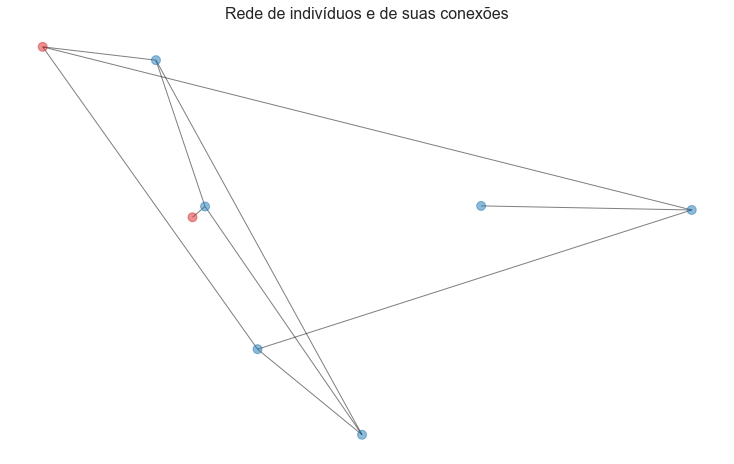

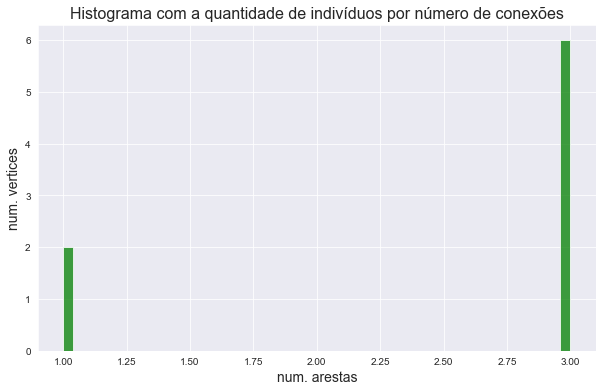

In [55]:
G_rs = nx.compose(G_s, G_r)
num_medio_conexoes_rs = analise_grafo(G_rs, info=True, node_size=80, pos=attr_pos, hist=True)

In [56]:
nx.to_numpy_array(G_rs, weight='taxa de transmissao')

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1., 0.]])

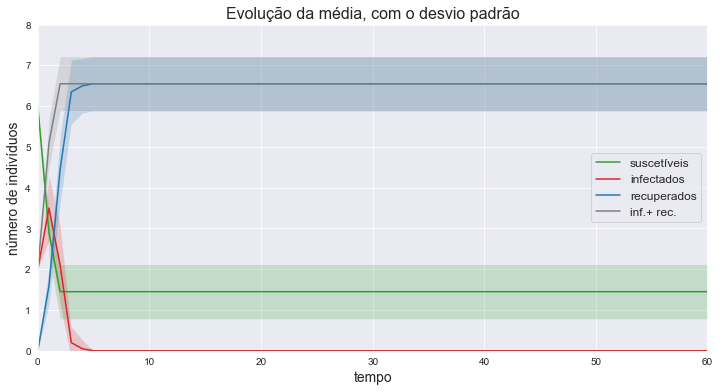

CPU times: user 1.47 s, sys: 183 ms, total: 1.66 s
Wall time: 1.67 s


In [57]:
%%time
redes_rs = [G_r, G_s]
redes_tx_transmissao_rs = [pop_tx_transmissao_r, pop_tx_transmissao_s]
X_rs = evolucao_modelo_individual(pop_estado_0, pop_posicoes, redes_rs, redes_tx_transmissao_rs,
                                  pop_fator_tx_transmissao_c, gamma, f_kernel,
                                  dados_temporais, num_sim, show='sd')

In [58]:
attr_transmissao_edge_r = {(i, j):
                           {'taxa de transmissao': beta_r / (1+G_r.degree(i))**alpha}
                           for (i,j) in G_r.edges()
                          }

attr_transmissao_edge_s = {(i, j):
                           {'taxa de transmissao': beta_s / (1+G_s.degree(i))}
                           for (i,j) in G_s.edges()
                          }

G_r_old = G_r.copy()
G_s_old = G_s.copy()

nx.set_edge_attributes(G_r_old, attr_transmissao_edge_r)

nx.set_edge_attributes(G_s_old, attr_transmissao_edge_s)

G_rs_old = nx.compose(G_s_old, G_r_old)

for (u, v, w) in G_rs_old.edges.data('taxa de transmissao', default=0):
    if (u, v) in G_s_old.edges and (u,v) in G_r.edges:
        G_rs_old.edges[u, v]['taxa de transmissao'] = \
            G_r_old.edges[u,v]['taxa de transmissao'] + G_s_old.edges[u,v]['taxa de transmissao']
        
G_a_old = nx.compose_all([G_c, G_s_old, G_r_old])

for (u, v, w) in G_c.edges.data('taxa de transmissao', default=0):
    G_a_old.edges[u,v]['taxa de transmissao'] = G_c.edges[u,v]['taxa de transmissao']
    if (u, v) in G_s.edges:
        G_a_old.edges[u, v]['taxa de transmissao'] += G_s_old.edges[u,v]['taxa de transmissao']
    if (u, v) in G_r.edges:
        G_a_old.edges[u, v]['taxa de transmissao'] += G_r_old.edges[u,v]['taxa de transmissao']

In [59]:
nx.to_numpy_array(G_r_old, weight='taxa de transmissao')

array([[0.        , 0.        , 1.72304753, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.72304753, 0.        ,
        0.        , 0.        , 0.        ],
       [1.72304753, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 1.72304753, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.72304753, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.72304753,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.72304753],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.72304753, 0.        ]])

In [60]:
nx.to_numpy_array(G_s_old, weight='taxa de transmissao')

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0.]])

In [61]:
nx.to_numpy_array(G_rs_old, weight='taxa de transmissao')

array([[0.        , 0.        , 1.72304753, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.72304753, 1.        ,
        0.        , 0.        , 1.        ],
       [1.72304753, 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        ],
       [0.        , 1.72304753, 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        1.72304753, 0.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        , 1.72304753,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.72304753],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.72304753, 0.        ]])

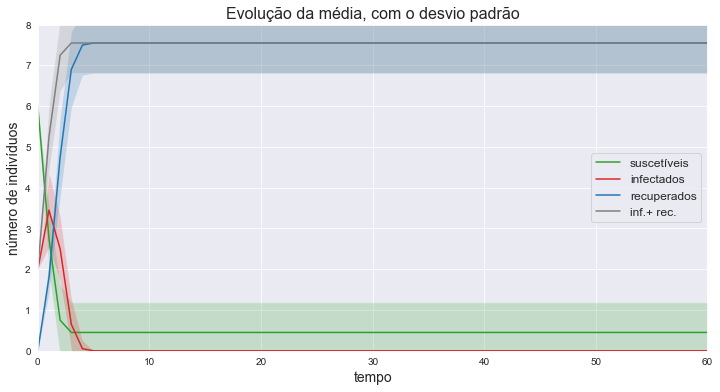

CPU times: user 1.15 s, sys: 19.1 ms, total: 1.17 s
Wall time: 1.32 s


In [62]:
%%time
X_rs_old = evolucao_grafo_estruturado(pop_estado_0, G_rs_old, gamma, tempos, num_sim, show='sd')

### Just one step

In [63]:
def passo_grafo_estruturado(num_pop, populacao, T_prob_nao_infeccao, prob_nao_recuperacao):

    # gera uma matriz cheia aleatória (números em [0.0,1.0))
    A_random = np.random.rand(num_pop, num_pop)

    # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
    pop_suscetiveis = np.select([populacao==1], [populacao])

    # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectado/contagioso
    pop_infectados = np.select([populacao==2], [populacao])/2

    # cria uma matriz aleatória de risco, mantendo apenas as conexões que envolvem infectados
    A_risco_random = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_random)

    # filtra a matriz aleatória mantendo apenas os contatos entre um suscetível e um infectado
    A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco_random)

    # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
    A_infectados = np.select([A_contatos > T_prob_nao_infeccao], [np.ones([num_pop, num_pop])])

    # obtém novos infectados
    pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_pop)])

    # filtra matriz aleatória com a diagonal
    pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)

    # obtém novos recuperados
    pop_novos_recuperados = np.select([pop_recuperando > prob_nao_recuperacao], [np.ones(num_pop)])

    # atualiza população adicionando um aos que avançaram de estágio
    populacao_nova = populacao + pop_novos_infectados + pop_novos_recuperados

    # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
    # a independência desses eventos aleatórios (tanto quanto se leve em consideração
    # que os números gerados são pseudo-aleatórios)

    return populacao_nova




In [64]:

dt = 1
prob_nao_recuperacao = np.exp(-gamma*dt)
T_adj = nx.to_numpy_matrix(G_rs_old, weight = 'taxa de transmissao')
T_prob_nao_infeccao = np.exp(-dt*T_adj)

In [65]:

X_rs_passo = passo_modelo_individual(pop_estado_0, redes_rs, redes_tx_transmissao_rs, 
                                     pop_fator_tx_transmissao_c, 
                                     prob_nao_recuperacao, pop_posicoes, f_kernel, dt)

In [66]:
X_rs_old_passo = passo_grafo_estruturado(num_pop, pop_estado_0, T_prob_nao_infeccao, prob_nao_recuperacao)

In [67]:
print(pop_estado_0)
print(X_rs_passo)
print(X_rs_old_passo)

[2. 2. 1. 1. 1. 1. 1. 1.]
[3. 3. 2. 2. 2. 1. 1. 2.]
[3. 2. 2. 1. 2. 1. 1. 2.]


In [68]:
T_adj

matrix([[0.        , 0.        , 1.72304753, 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.72304753, 1.        ,
         0.        , 0.        , 1.        ],
        [1.72304753, 0.        , 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        ],
        [0.        , 1.72304753, 1.        , 0.        , 0.        ,
         1.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         1.72304753, 0.        , 1.        ],
        [0.        , 0.        , 1.        , 1.        , 1.72304753,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.72304753],
        [0.        , 1.        , 0.        , 0.        , 1.        ,
         0.        , 1.72304753, 0.        ]])

# Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020 (Free Download).](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).)


- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2). 

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/18332436/); veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1).

- [Landscan data](https://landscan.ornl.gov/): dados da distribuição global da população, com resolução da ordem de $1\,km^2$ ($30''\times 30''$).

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

- [I. Z. Kiss, J. Miller & P. L. Simon (2017), Mathematics of Epidemics on Networks: From Exact to Approximate Models, Springer-Verlag.](https://www.springer.com/br/book/9783319508047)

Veja a página [Imperial College - Covid 19](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/) para mais relatórios, publicações e outras informações do Imperial College.

<!--NAVIGATOR-->

---
[<- Modelos individuais estocásticos com múltiplas estruturas de conexão - parte III](10.00.Aula-Modelos_individuais_multiplas_estruturas_3.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 